In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from sklearn.metrics import classification_report, accuracy_score
from pandas.plotting import scatter_matrix

In [2]:
df =pd.read_csv("/kaggle/input/chocolate-bar-ratings/flavors_of_cacao.csv")
df.head()

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [3]:
#having a look at some of the basic info about the data
def info(df):
    
    # Shape of the dataframe
    print("Number of Instances:",df.shape[0])
    print("Number of Features:",df.shape[1])
    
    # Summary Stats
    print("\nSummary Stats:")
    print(df.describe())
    
    # Missing Value Inspection
    print("\nMissing Values:")
    print(df.isna().sum())

info(df)

Number of Instances: 1795
Number of Features: 9

Summary Stats:
               REF  Review\nDate       Rating
count  1795.000000   1795.000000  1795.000000
mean   1035.904735   2012.325348     3.185933
std     552.886365      2.927210     0.478062
min       5.000000   2006.000000     1.000000
25%     576.000000   2010.000000     2.875000
50%    1069.000000   2013.000000     3.250000
75%    1502.000000   2015.000000     3.500000
max    1952.000000   2017.000000     5.000000

Missing Values:
Company \n(Maker-if known)           0
Specific Bean Origin\nor Bar Name    0
REF                                  0
Review\nDate                         0
Cocoa\nPercent                       0
Company\nLocation                    0
Rating                               0
Bean\nType                           1
Broad Bean\nOrigin                   1
dtype: int64


In [4]:
#changing the feature names and making it more readable

cols = list(df.columns)

# replacing newline characters and spaces in the feature names
def rec_features(feature_names):
    rec_feat = []
    for f in feature_names:
        rec_feat.append(((f.casefold()).replace("\n","_")).replace(" ","_"))
    return rec_feat

print("Feature Names before Cleaning:")
print(cols)
print("\nFeature Names after Cleaning:")
print(rec_features(cols))

# handling the feature name company
new_feature_names = rec_features(cols)
new_feature_names[0] = "company"

# Re-assigning feature names
df=df.rename(columns=dict(zip(df.columns,new_feature_names)))
df.dtypes

Feature Names before Cleaning:
['Company\xa0\n(Maker-if known)', 'Specific Bean Origin\nor Bar Name', 'REF', 'Review\nDate', 'Cocoa\nPercent', 'Company\nLocation', 'Rating', 'Bean\nType', 'Broad Bean\nOrigin']

Feature Names after Cleaning:
['company\xa0_(maker-if_known)', 'specific_bean_origin_or_bar_name', 'ref', 'review_date', 'cocoa_percent', 'company_location', 'rating', 'bean_type', 'broad_bean_origin']


company                              object
specific_bean_origin_or_bar_name     object
ref                                   int64
review_date                           int64
cocoa_percent                        object
company_location                     object
rating                              float64
bean_type                            object
broad_bean_origin                    object
dtype: object

In [5]:
# The missing values
df[['bean_type', 'broad_bean_origin']].head()

,bean_type,broad_bean_origin
0,,Sao Tome
1,,Togo
2,,Togo
3,,Togo
4,,Peru


In [6]:
#A look at all the values 
print(df['bean_type'].value_counts().head())

                        887
Trinitario              419
Criollo                 153
Forastero                87
Forastero (Nacional)     52
Name: bean_type, dtype: int64


In [7]:
#What the missing spaces are encoded as
list(df['bean_type'][0:5])

['\xa0', '\xa0', '\xa0', '\xa0', '\xa0']

In [8]:
# Replace spaces with NONE to make the dataset cleaner

def space(x):
    if(x is "\xa0"):
        return "None"
    
df['bean_type'] = df['bean_type'].apply(space)
df.head()

,company,specific_bean_origin_or_bar_name,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,None,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,None,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,None,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,None,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,None,Peru


In [9]:
# converting cocoa % to numerical values
df['cocoa_percent']=df['cocoa_percent'].str.replace('%','').astype(float)/100
df.head()

,company,specific_bean_origin_or_bar_name,ref,review_date,cocoa_percent,company_location,rating,bean_type,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,0.63,France,3.75,None,Sao Tome
1,A. Morin,Kpime,1676,2015,0.70,France,2.75,None,Togo
2,A. Morin,Atsane,1676,2015,0.70,France,3.00,None,Togo
3,A. Morin,Akata,1680,2015,0.70,France,3.50,None,Togo
4,A. Morin,Quilla,1704,2015,0.70,France,3.50,None,Peru


Cocoa percentage in chocolate over the years

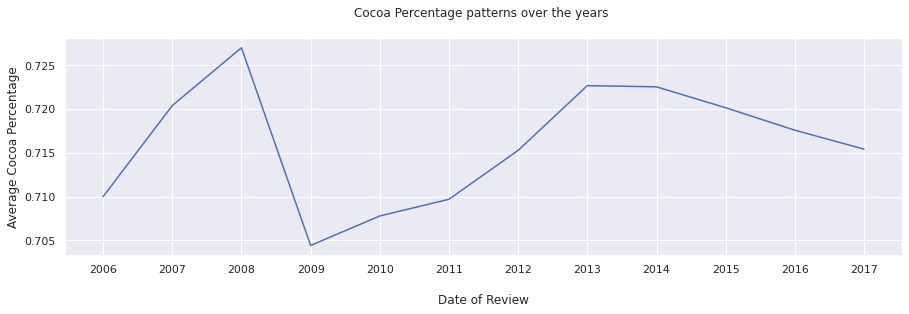

In [10]:
dcoco = df.groupby('review_date').aggregate({'cocoa_percent':'mean'})
dcoco = dcoco.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(x='review_date', y='cocoa_percent', data=dcoco)
ax.set(xticks=dcoco.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Cocoa Percentage")
plt.title("Cocoa Percentage patterns over the years \n")
plt.show()

Rating of chocolate bars over the years

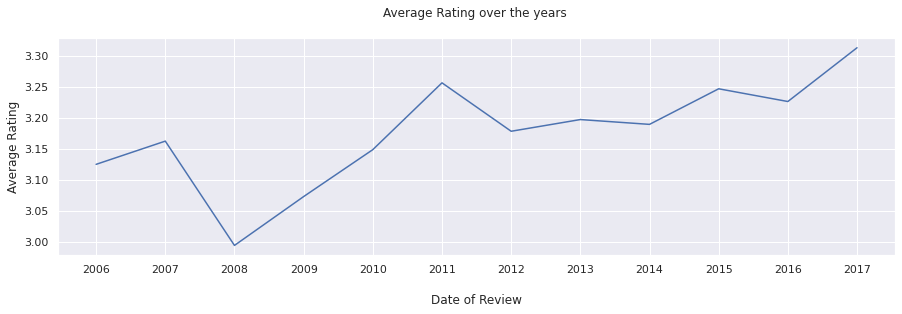

In [11]:
drate = df.groupby('review_date').aggregate({'rating':'mean'})
drate = drate.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(x='review_date', y='rating', data=drate)
ax.set(xticks=drate.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Rating")
plt.title("Average Rating over the years \n")
plt.show()

Chocolate companies

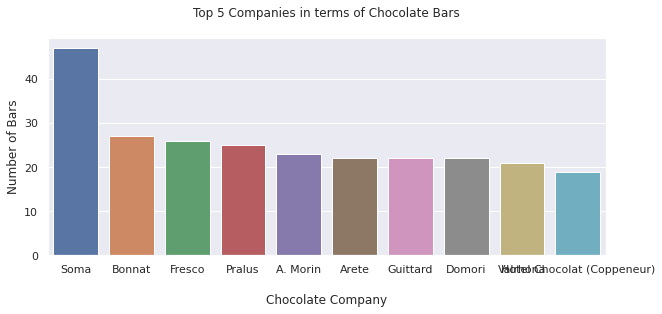

In [12]:
# Top 10 companies in terms of chocolate bars 
d = df['company'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 10 companies

# Plotting
sns.set()
plt.figure(figsize=(10,4))
sns.barplot(x='index', y='company', data=d)
plt.xlabel("\nChocolate Company")
plt.ylabel("Number of Bars")
plt.title("Top 5 Companies in terms of Chocolate Bars\n")
plt.show()

Some produces max number of chocolate bars.

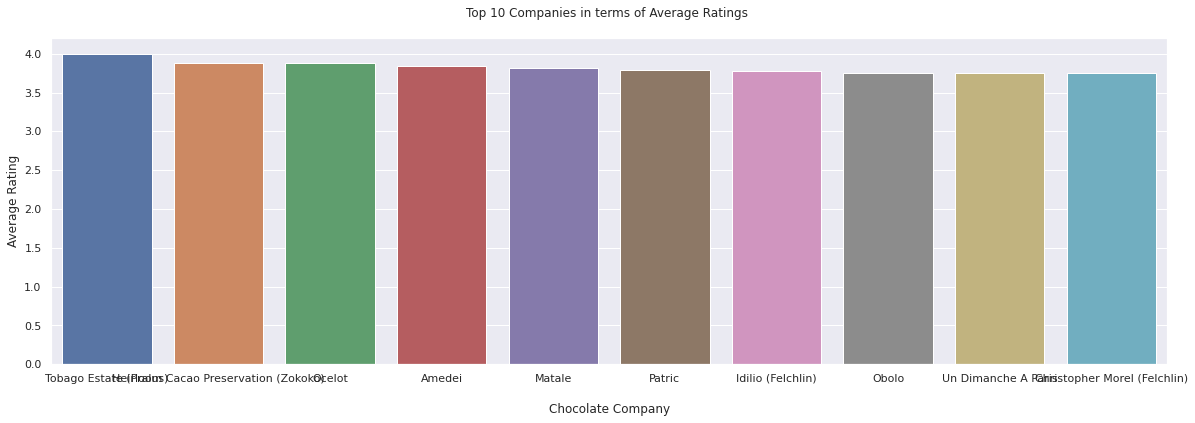

In [13]:
# Top 10 companies in terms of average ratings
d2 = df.groupby('company').aggregate({'rating':'mean'})
d2 = d2.sort_values('rating', ascending=False).head(10)
d2 = d2.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(20, 6))
sns.barplot(x='company', y='rating', data=d2)
plt.xlabel("\nChocolate Company")
plt.ylabel("Average Rating")
plt.title("Top 10 Companies in terms of Average Ratings \n")
plt.show()

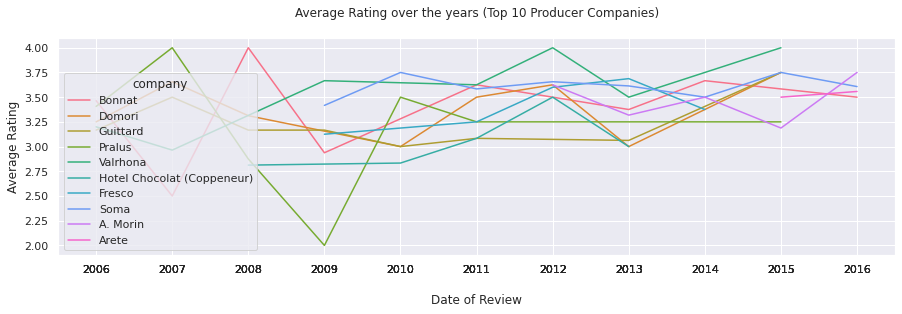

In [14]:
# Average rating over the years wrt companies
top10_dict = {}
# Top 10 companies in terms of chocolate bars in this dataset
d = df['company'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 10 companies
for element in list(d['index']):
    temp = df[df['company']==element]
    top10_dict[element]=temp

top10_list = list(top10_dict.keys())

# Rating over the years
d7 = df.groupby(['review_date', 'company']).aggregate({'rating':'mean'})
d7 = d7.reset_index()
d7 = d7[d7['company'].isin(top10_list)]


# Plotting
sns.set()
plt.figure(figsize=(15, 4))
ax = sns.lineplot(x='review_date', y='rating', hue="company", data=d7, palette="husl")
ax.set(xticks=d7.review_date.values)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Rating")
plt.title("Average Rating over the years (Top 10 Producer Companies)\n")
plt.show()

Analysing the largest chocolate bar producer - Some

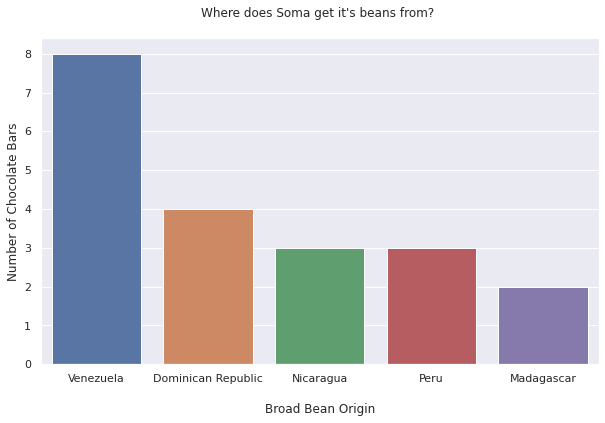

In [15]:
soma = df[df['company']=='Soma']
d3 = soma['broad_bean_origin'].value_counts().sort_values(ascending=False).head(5)
d3 = pd.DataFrame(d3)
d3 = d3.reset_index()
# Plotting
sns.set()
plt.figure(figsize=(10, 6))
sns.barplot(x='index', y='broad_bean_origin', data=d3)
plt.xlabel("\nBroad Bean Origin")
plt.ylabel("Number of Chocolate Bars")
plt.title("Where does Soma get it's beans from? \n")
plt.show()

Visualizing Soma's chocolate bar rating

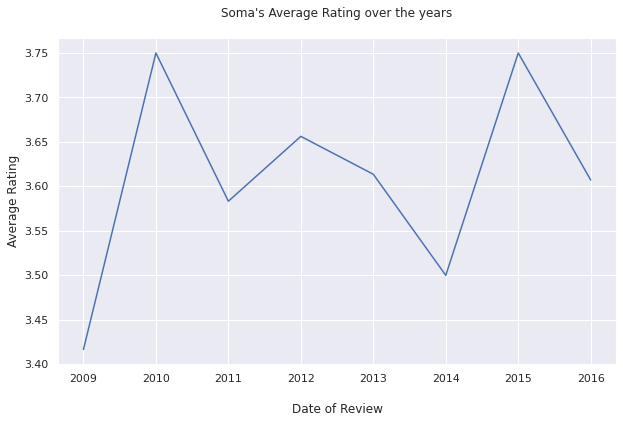

In [16]:
#Soma's performance over the years
d4 = soma.groupby('review_date').aggregate({'rating':'mean'})
d4 = d4.reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(x='review_date', y='rating', data=d4)
plt.xlabel("\nDate of Review")
plt.ylabel("Average Rating")
plt.title("Soma's Average Rating over the years\n")
plt.show()

Categorizing chocolate bars based on their rating

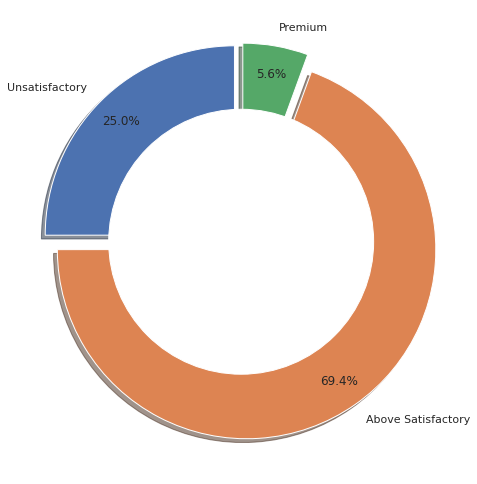

In [17]:
unsatisfactory = df[df['rating'] < 3.0]
satisfactory = df[(df['rating'] >= 3.0) & (df.rating < 4)]
pre_elite = df[df['rating'] >= 4.0]
label_names=['Unsatisfactory','Above Satisfactory','Premium']
sizes = [unsatisfactory.shape[0],satisfactory.shape[0],pre_elite.shape[0]]

# Making the donut plot
explode = (0.05,0.05,0.05)
my_circle=plt.Circle((0,0),0.7,color='white')
plt.figure(figsize=(7,7))
plt.pie(sizes,labels=label_names,explode=explode,autopct='%1.1f%%',pctdistance=0.85,startangle=90,shadow=True)
fig=plt.gcf()
fig.gca().add_artist(my_circle)
plt.axis('equal')
plt.tight_layout()
plt.show()

Counts of each rating of chocolate bars

Rating: 3.5 Reviews: 392
Rating: 3.0 Reviews: 341
Rating: 3.25 Reviews: 303
Rating: 2.75 Reviews: 259
Rating: 3.75 Reviews: 210
Rating: 2.5 Reviews: 127
Rating: 4.0 Reviews: 98
Rating: 2.0 Reviews: 32
Rating: 2.25 Reviews: 14
Rating: 1.5 Reviews: 10
Rating: 1.0 Reviews: 4
Rating: 1.75 Reviews: 3
Rating: 5.0 Reviews: 2


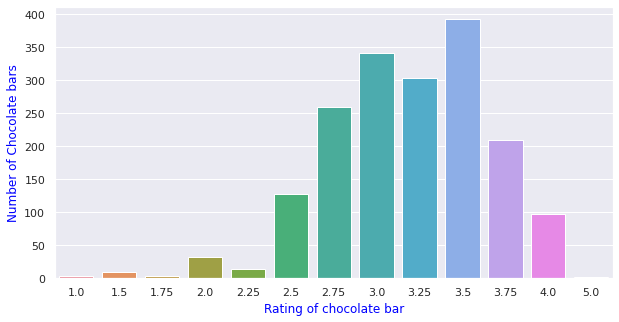

In [18]:
# The counts of each rating
r=list(df['rating'].value_counts())
rating=df['rating'].value_counts().index.tolist()
rat=dict(zip(rating,r))
for key,val in rat.items():
    print ('Rating:',key,'Reviews:',val)
plt.figure(figsize=(10,5))
sns.countplot(x='rating',data=df)
plt.xlabel('Rating of chocolate bar',size=12,color='blue')
plt.ylabel('Number of Chocolate bars',size=12,color='blue')
plt.show()

Distribution of chocolate bars according to their cocoa percentage

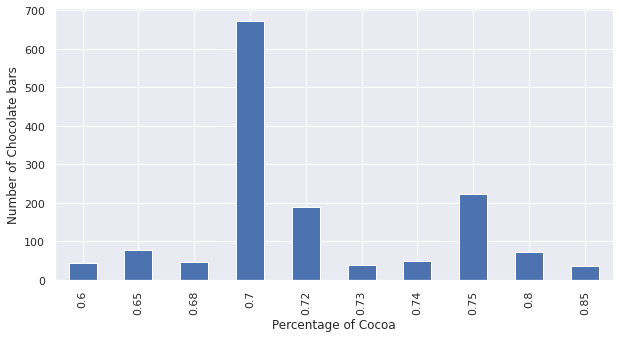

In [19]:
#Top 10 cocoa % is taken
plt.figure(figsize=(10,5))
df['cocoa_percent'].value_counts().head(10).sort_index().plot.bar()
plt.xlabel('Percentage of Cocoa',size=12)
plt.ylabel('Number of Chocolate bars',size=12)
plt.show()

Where the best cocoa beans are grown (based on rating)

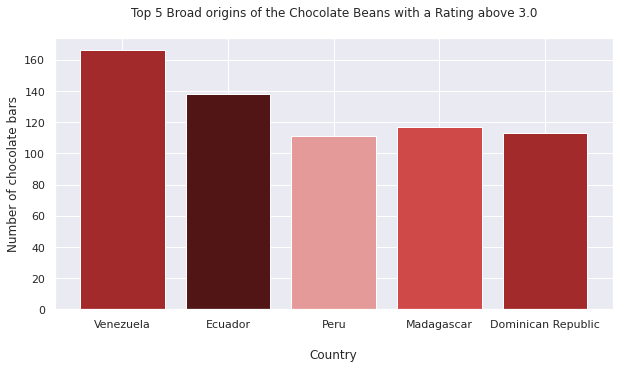

{'Venezuela': 166, 'Ecuador': 138, 'Peru': 111, 'Madagascar': 117, 'Dominican Republic': 113}


In [20]:
countries=df['broad_bean_origin'].value_counts().index.tolist()[:5]
satisfactory={} 
for j in countries:
    c=0
    b=df[df['broad_bean_origin']==j]
    br=b[b['rating']>=3] 
    for i in br['rating']:
        c+=1
        satisfactory[j]=c    

# Code to visualize the countries that give best cocoa beans
li=satisfactory.keys()
plt.figure(figsize=(10,5))
plt.bar(range(len(satisfactory)), satisfactory.values(), align='center',color=['#a22a2a','#511515','#e59a9a','#d04949','#a22a2a'])
plt.xticks(range(len(satisfactory)), list(li))
plt.xlabel('\nCountry')
plt.ylabel('Number of chocolate bars')
plt.title("Top 5 Broad origins of the Chocolate Beans with a Rating above 3.0\n")
plt.show()

print(satisfactory)

Analysing the top chocolate bar producing countries (in terms of quantity)

Top Chocolate Producing Countries in the World

U.S.A.    764
France    156
Canada    125
U.K.       96
Italy      63
Name: company_location, dtype: int64


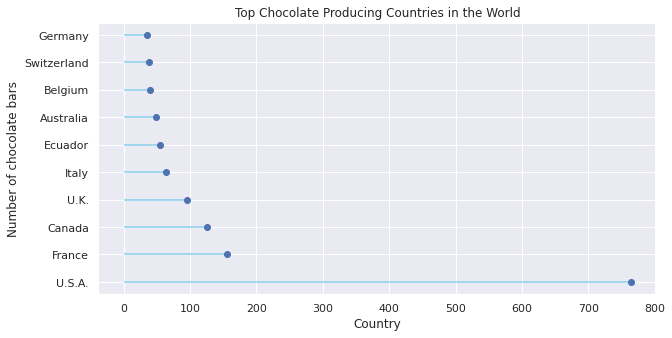

In [21]:
print ('Top Chocolate Producing Countries in the World\n')
country=list(df['company_location'].value_counts().head(10).index)
choco_bars=list(df['company_location'].value_counts().head(10))
prod_ctry=dict(zip(country,choco_bars))
print(df['company_location'].value_counts().head())

plt.figure(figsize=(10,5))
plt.hlines(y=country,xmin=0,xmax=choco_bars,color='skyblue')
plt.plot(choco_bars,country,"o")
plt.xlabel('Country')
plt.ylabel('Number of chocolate bars')
plt.title("Top Chocolate Producing Countries in the World")
plt.show()

Visualizing countries that produce best chocolates

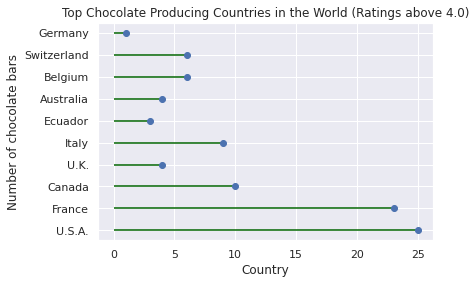

{'U.S.A.': 25, 'France': 23, 'Canada': 10, 'U.K.': 4, 'Italy': 9, 'Ecuador': 3, 'Australia': 4, 'Belgium': 6, 'Switzerland': 6, 'Germany': 1}


In [22]:
countries=country
best_choc={}
for j in countries:
    c=0
    b=df[df['company_location']==j]
    br=b[b['rating']>=4] 
    for i in br['rating']:
        c+=1
        best_choc[j]=c    


li=best_choc.keys()
# The lollipop plot
plt.hlines(y=li,xmin=0,xmax=best_choc.values(),color='darkgreen')
plt.plot(best_choc.values(),li,"o")
plt.xlabel('Country')
plt.ylabel('Number of chocolate bars')
plt.title("Top Chocolate Producing Countries in the World (Ratings above 4.0)")
plt.show()
print(best_choc)

In [23]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
dataset = pd.read_csv("/kaggle/input/chocolate-bar-ratings/flavors_of_cacao.csv")

In [25]:
dataset.columns = ['Company', 'Specific_Bean_Origin_nor_Bar_Name',
       'REF', 'Review_Date', 'Cocoa_Percent', 'Company_Location', 'Rating',
       'Bean_Type', 'Broad_Bean_Origin']

In [26]:
dataset.head()

,Company,Specific_Bean_Origin_nor_Bar_Name,REF,Review_Date,Cocoa_Percent,Company_Location,Rating,Bean_Type,Broad_Bean_Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


In [27]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1795 entries, 0 to 1794
Data columns (total 9 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Company                            1795 non-null   object 
 1   Specific_Bean_Origin_nor_Bar_Name  1795 non-null   object 
 2   REF                                1795 non-null   int64  
 3   Review_Date                        1795 non-null   int64  
 4   Cocoa_Percent                      1795 non-null   object 
 5   Company_Location                   1795 non-null   object 
 6   Rating                             1795 non-null   float64
 7   Bean_Type                          1794 non-null   object 
 8   Broad_Bean_Origin                  1794 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 126.3+ KB


In [28]:
dataset.describe()

,REF,Review_Date,Rating
count,1795.000000,1795.000000,1795.000000
mean,1035.904735,2012.325348,3.185933
std,552.886365,2.927210,0.478062
min,5.000000,2006.000000,1.000000
25%,576.000000,2010.000000,2.875000
50%,1069.000000,2013.000000,3.250000
75%,1502.000000,2015.000000,3.500000
max,1952.000000,2017.000000,5.000000


In [29]:
dataset.columns

Index(['Company', 'Specific_Bean_Origin_nor_Bar_Name', 'REF', 'Review_Date',
       'Cocoa_Percent', 'Company_Location', 'Rating', 'Bean_Type',
       'Broad_Bean_Origin'],
      dtype='object')

In [30]:
for column_name in dataset.columns:
    print(column_name + "::  {}".format(len(dataset[column_name].value_counts())))

Company::  416
Specific_Bean_Origin_nor_Bar_Name::  1039
REF::  440
Review_Date::  12
Cocoa_Percent::  45
Company_Location::  60
Rating::  13
Bean_Type::  41
Broad_Bean_Origin::  100


<AxesSubplot:>

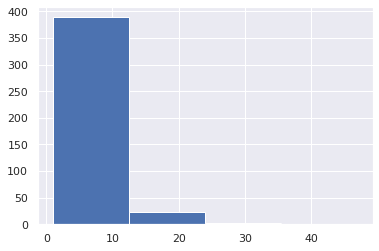

In [31]:
dataset['Company'].value_counts().hist(bins = 4)

In [32]:
dataset['Specific_Bean_Origin_nor_Bar_Name'].value_counts()[dataset['Specific_Bean_Origin_nor_Bar_Name'].value_counts() > 10]

Madagascar            57
Peru                  45
Ecuador               42
Dominican Republic    37
Venezuela             21
Chuao                 19
Sambirano             19
Ocumare               17
Ghana                 15
Papua New Guinea      15
Belize                13
Bolivia               12
Costa Rica            11
La Red                11
Brazil                11
Tanzania              11
Trinidad              11
Grenada               11
Porcelana             11
Name: Specific_Bean_Origin_nor_Bar_Name, dtype: int64

<AxesSubplot:>

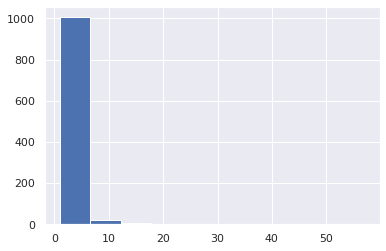

In [33]:
dataset['Specific_Bean_Origin_nor_Bar_Name'].value_counts().hist(bins = 10)

In [34]:
dataset['Company'].value_counts()[dataset['Company'].value_counts() > 18]

Soma                          47
Bonnat                        27
Fresco                        26
Pralus                        25
A. Morin                      23
Arete                         22
Guittard                      22
Domori                        22
Valrhona                      21
Hotel Chocolat (Coppeneur)    19
Name: Company, dtype: int64

In [35]:
dataset['Cocoa_Percent'] = dataset.Cocoa_Percent.apply(lambda x: float(x[:-1])/ 100)

In [36]:
dataset.Review_Date.value_counts()

2015    285
2014    247
2016    219
2012    195
2013    184
2011    165
2009    123
2010    111
2008     93
2007     77
2006     72
2017     24
Name: Review_Date, dtype: int64

In [37]:
dataset.Company_Location.value_counts()[dataset.Company_Location.value_counts() > 30]

U.S.A.         764
France         156
Canada         125
U.K.            96
Italy           63
Ecuador         54
Australia       49
Belgium         40
Switzerland     38
Germany         35
Name: Company_Location, dtype: int64

In [38]:
for new_column in ['USA', 'France', 'Canada', 'UK', 'Italy', 'Ecuador', 'Australia', 'Belgium', 'Switzerland', 'Germany']:
    dataset[new_column] = 0

In [39]:
dataset.Bean_Type.value_counts()/1795

                            0.494150
Trinitario                  0.233426
Criollo                     0.085237
Forastero                   0.048468
Forastero (Nacional)        0.028969
Blend                       0.022841
Criollo, Trinitario         0.021727
Forastero (Arriba)          0.020613
Criollo (Porcelana)         0.005571
Trinitario, Criollo         0.005014
Forastero (Parazinho)       0.004457
Forastero (Arriba) ASS      0.003343
Nacional (Arriba)           0.001671
Matina                      0.001671
EET                         0.001671
Beniano                     0.001671
Criollo (Ocumare 61)        0.001114
Trinitario, Forastero       0.001114
Trinitario (85% Criollo)    0.001114
Forastero (Catongo)         0.001114
Criollo, Forastero          0.001114
Amazon, ICS                 0.001114
Criollo (Amarru)            0.001114
Amazon mix                  0.001114
Nacional                    0.001114
Criollo (Ocumare)           0.000557
Criollo (Ocumare 67)        0.000557
T

<AxesSubplot:>

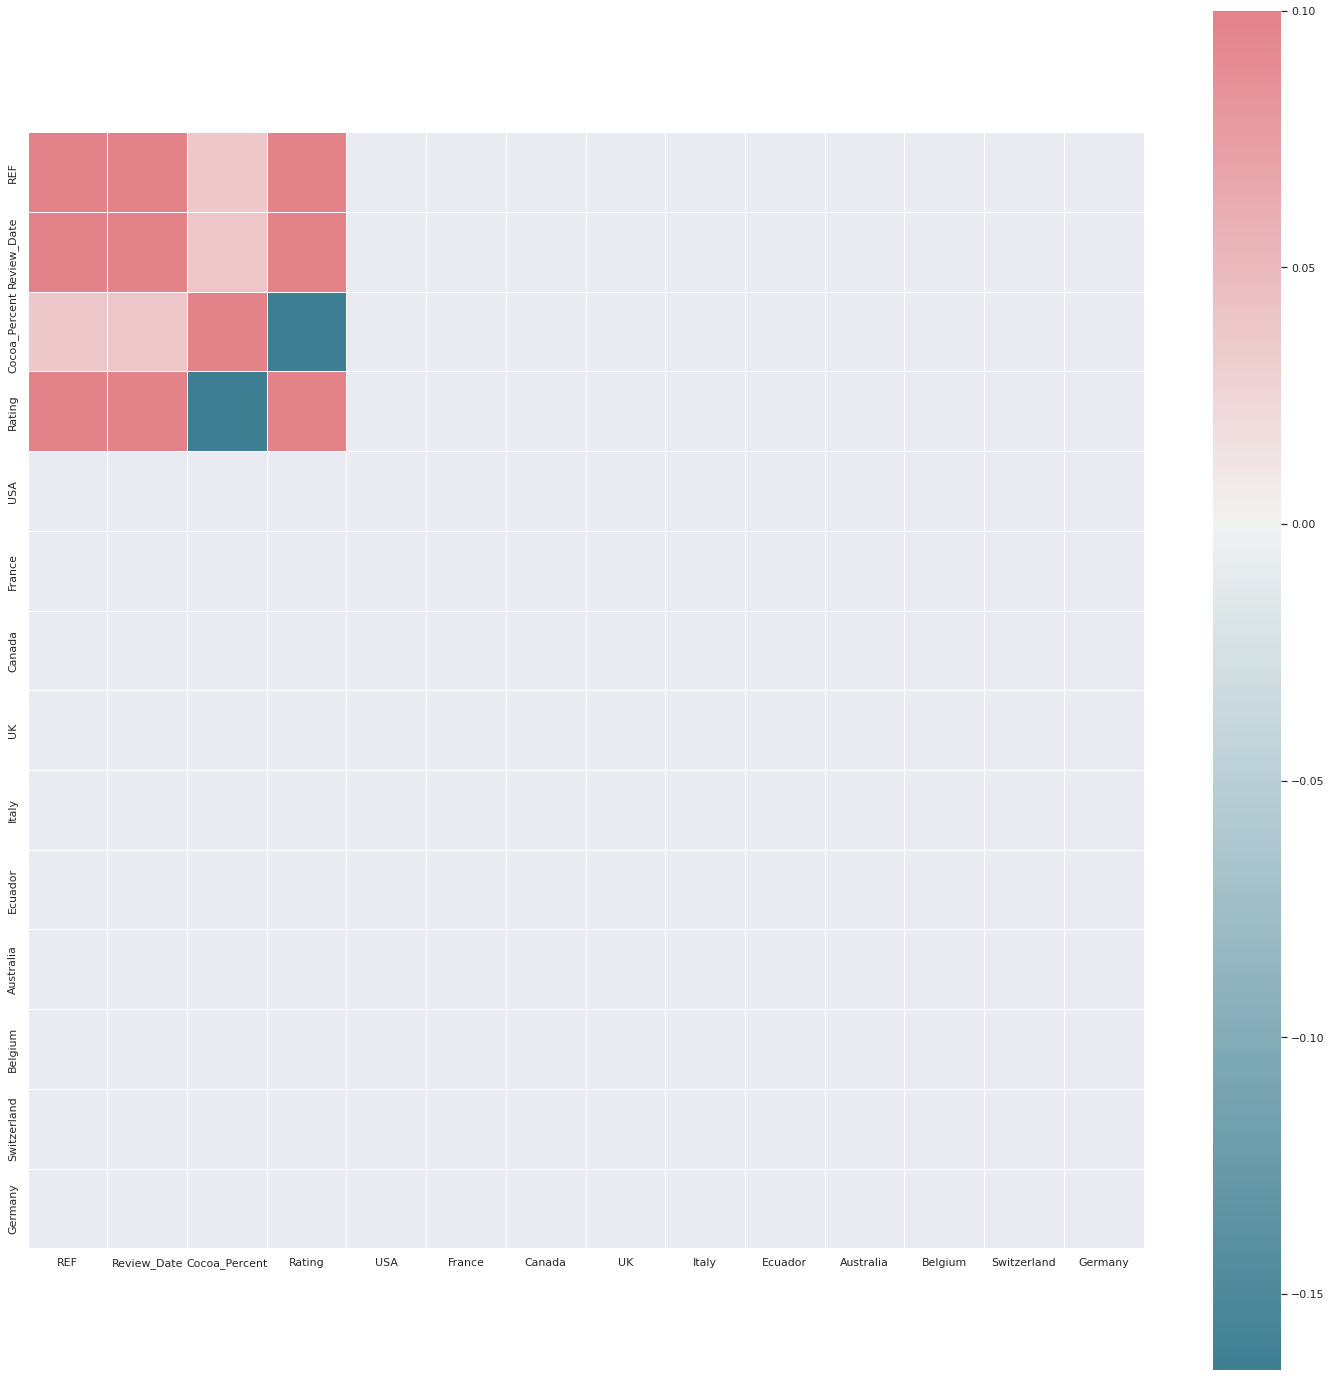

In [40]:
corr = dataset.corr()
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.1, center=0,
            square=True, linewidths=.5)

In [41]:
training_testing = dataset[['REF', "Review_Date", "Cocoa_Percent", 'Rating', 'USA', 'France', 'Canada', 'UK', 'Italy', 'Ecuador', 'Australia', 'Belgium', 'Switzerland', 'Germany']]

In [42]:
training_testing

,REF,Review_Date,Cocoa_Percent,Rating,USA,France,Canada,UK,Italy,Ecuador,Australia,Belgium,Switzerland,Germany
0,1876,2016,0.63,3.75,0,0,0,0,0,0,0,0,0,0
1,1676,2015,0.70,2.75,0,0,0,0,0,0,0,0,0,0
2,1676,2015,0.70,3.00,0,0,0,0,0,0,0,0,0,0
3,1680,2015,0.70,3.50,0,0,0,0,0,0,0,0,0,0
4,1704,2015,0.70,3.50,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790,647,2011,0.70,3.75,0,0,0,0,0,0,0,0,0,0
1791,749,2011,0.65,3.00,0,0,0,0,0,0,0,0,0,0
1792,749,2011,0.65,3.50,0,0,0,0,0,0,0,0,0,0
1793,781,2011,0.62,3.25,0,0,0,0,0,0,0,0,0,0


In [43]:
training_testing['Rating']

0       3.75
1       2.75
2       3.00
3       3.50
4       3.50
        ... 
1790    3.75
1791    3.00
1792    3.50
1793    3.25
1794    3.00
Name: Rating, Length: 1795, dtype: float64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  """


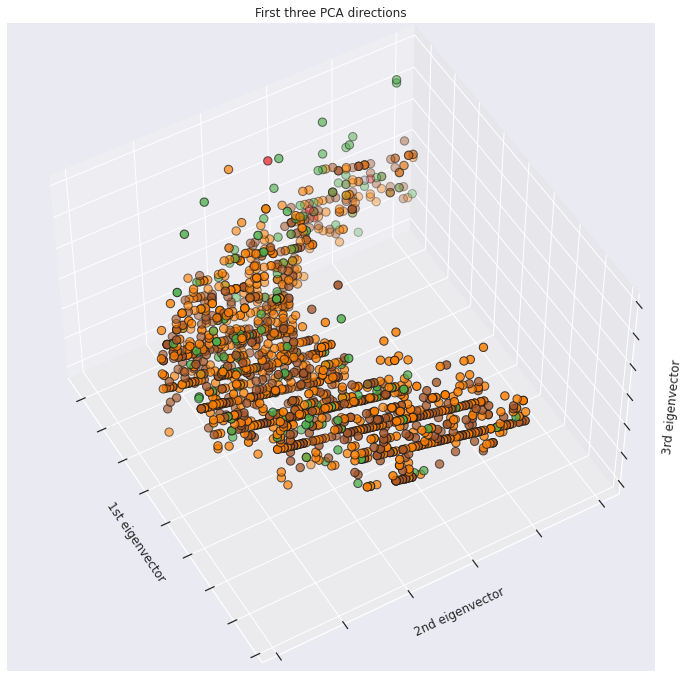

The number of features in the new subspace is  3


In [44]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(16, 9))
ax = Axes3D(fig, elev=-130, azim=30)
X_reduced = PCA(n_components=3).fit_transform(training_testing.drop(['Rating'], axis = 1))

ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=training_testing['Rating'].round(),
           cmap=plt.cm.Set1, edgecolor='k', s=70)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()
print("The number of features in the new subspace is " ,X_reduced.shape[1])

In [45]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=X_reduced[:, 0], y=X_reduced[:, 1], z=X_reduced[:, 2], mode='markers', marker=dict( size=4, color=training_testing['Rating'].round(), colorscale= "Portland", opacity=0.))])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [46]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
                        training_testing.drop(['Rating'], axis = 1), training_testing['Rating'], test_size=0.2, random_state=42)

In [47]:
x_train.shape

(1436, 13)

In [48]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=13),
        layers.Dense(64, activation='relu'),
        layers.Dense(125, activation='relu'),
        layers.Dense(1)
        ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [49]:
model = build_model()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [50]:
EPOCHS = 100
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')

history = model.fit(x_train, y_train, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=1, 
                    callbacks=[early_stop])

2021-12-23 05:19:19.993037: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
36/36 [==============================] - 1s 10ms/step - loss: 2080.9111 - mae: 30.9326 - mse: 2080.9111 - val_loss: 1415.5464 - val_mae: 35.3688 - val_mse: 1415.5464
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 589.9470 - mae: 22.4243 - mse: 589.9470 - val_loss: 335.6508 - val_mae: 16.9875 - val_mse: 335.6508
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 353.6738 - mae: 18.0341 - mse: 353.6738 - val_loss: 269.9442 - val_mae: 15.7559 - val_mse: 269.9442
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 194.3677 - mae: 12.9089 - mse: 194.3677 - val_loss: 313.2426 - val_mae: 17.6706 - val_mse: 313.2426
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 135.7872 - mae: 9.0188 - mse: 135.7872 - val_loss: 534.7288 - val_mae: 22.9885 - val_mse: 534.7288
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 79.5400 - mae: 5.8182 - mse: 79.5400 - val_loss: 30.0484 -

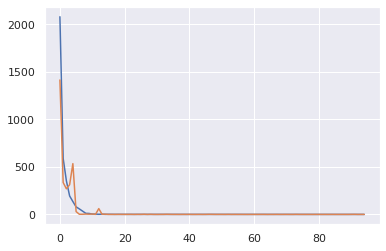

In [51]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])